# ARIMA Models 

In this notebook we will predict and visualize future values and calculate confidence level for the predictions, using ARIMA time series models.  


ARIMA (or Integrated ARMA) models are appropriate to use for a non-stationary series with significant dependence among values, but no seasonality. In this case our median home value series is non-stationary, but has little-to-no seasonailty, as shown in the Prophet Analysis. 

We hope that applying ARIMA Models to our time series will add additional insight and confidence into our Prophet analysis. 


In [5]:
#for debugging:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of src.utilities.ARIMA failed: Traceback (most recent call last):
  File "/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/brentsair/anaconda3/envs/zipcode/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstr

In [6]:
# Import necessary libraries
from src.utilities import ARIMA as ar
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


In [7]:
#Load the dataset 
df = pd.read_csv('../../data/raw/zillow_data.csv')


### Select one zipcode from our 5 zipcodes of interest

We have identified 5 zipcodes offering the highest forecasted growth from our Prophet Analyis. They are:

- 34982 - Fort Pierce, FL
- 33982 - Punta Gorda, FL
- 34951 - Fort Pierce, FL
- 37209 - Nashville, TN 
- 15201 - Pittshburgh, PA

Here we will use one of these zipcodes to develop our ARIMA pipeline. 

In [27]:
zipcode = 34982
df_zip = ar.prep_zip_for_ARIMA(df, zipcode)

## The ARIMA Time Series Model

The ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.



A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).



## Parameter Selection for the ARIMA Time Series Model


The first step towards fitting an ARIMA model is to find the values of `ARIMA(p,d,q)` that produce the best fit model. We will first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the statsmodels module and assess its overall quality. 

We chose to use a SARIMAX model as a standin for a more standard ARIMA model even though our time series does not have a significant seasonal affect. This is because the SARIMAX functions like an ARIMA model if a seasonal argument is not input, and the SARIMAX model from StatsModels has several functional methods such as `plot_diagonistics` which makes our analysis more efficient. 

`SARIMAX` detailed documentation can be viewed [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)


## AIC (Akaike Information Criterion) as Regularization Measure


For evaluating the model, we will use the AIC (Akaike Information Criterion) value. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. 

NOTE: 

* An overview of Akaike Information Criterion can be viewed [HERE](http://www.statisticshowto.com/akaikes-information-criterion/)

### The following cell executes a brute force method to identify the `p,d,q` parameters that minimze the AIC measure. 

In [12]:
combo = ar.ARIMA_param_gridsearch(df_zip, max_range = 2)

ARIMA (0, 0, 0) : AIC Calculated =6867.986508733736
ARIMA (0, 0, 1) : AIC Calculated =12774.799643436323
ARIMA (0, 1, 0) : AIC Calculated =4720.640987812769
ARIMA (0, 1, 1) : AIC Calculated =4361.456573244114
ARIMA (1, 0, 0) : AIC Calculated =4731.94474097475
ARIMA (1, 0, 1) : AIC Calculated =4518.039961728465
ARIMA (1, 1, 0) : AIC Calculated =3774.8913709547787
ARIMA (1, 1, 1) : AIC Calculated =3703.496310525852
pdq    (1, 1, 1)
aic       3703.5
Name: 7, dtype: object


## Fitting an ARIMA Time Series Model

We have now identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9746      0.016     62.805      0.000       0.944       1.005
ma.L1          0.5433      0.040     13.519      0.000       0.465       0.622
sigma2        7.7e+04   4244.815     18.140      0.000    6.87e+04    8.53e+04


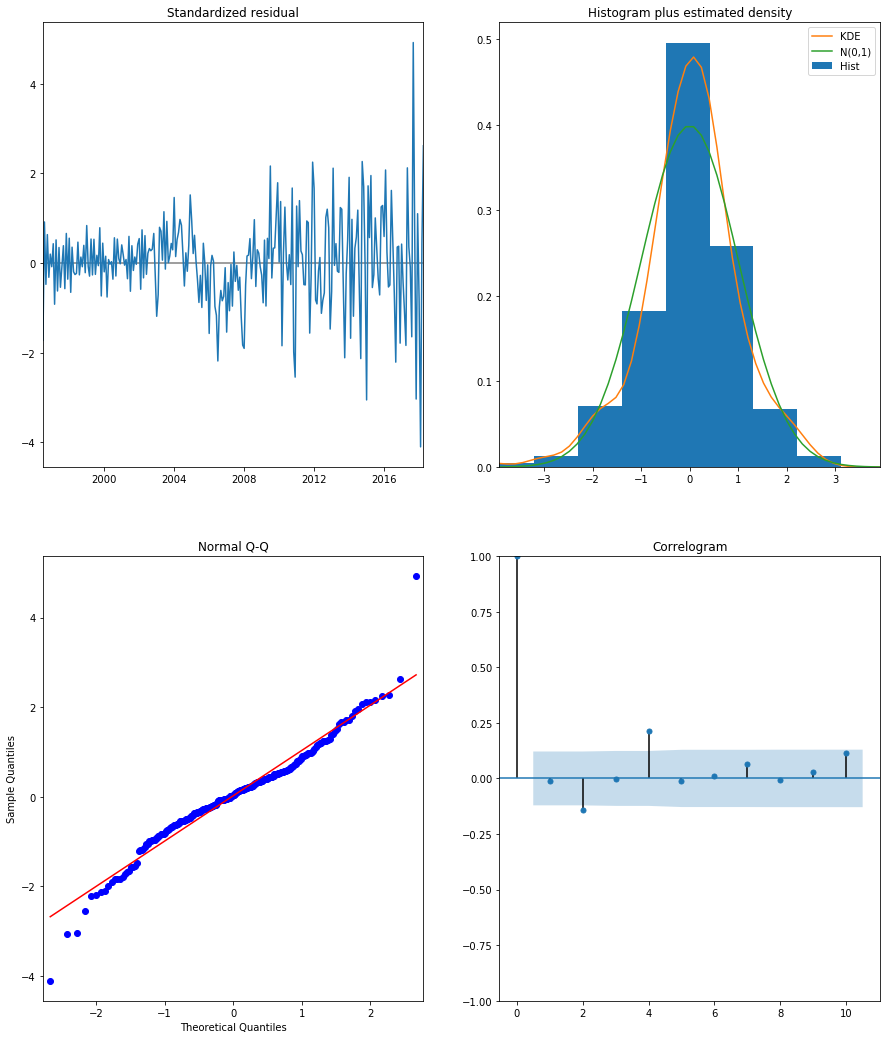

In [21]:
output = ar.ARIMA_MODEL(df_zip, combo)

The purpose here to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

The purpose here to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.


### These observations lead us to conclude that our model provides a satisfactory fit to help forecast future values.

### Validating the Model

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

In [24]:
#Use model to create predictions
pred, pred_conf = ar.ARIMA_predictions(df_zip, output)

The Root Mean Squared Error of our forecasts is 279.7


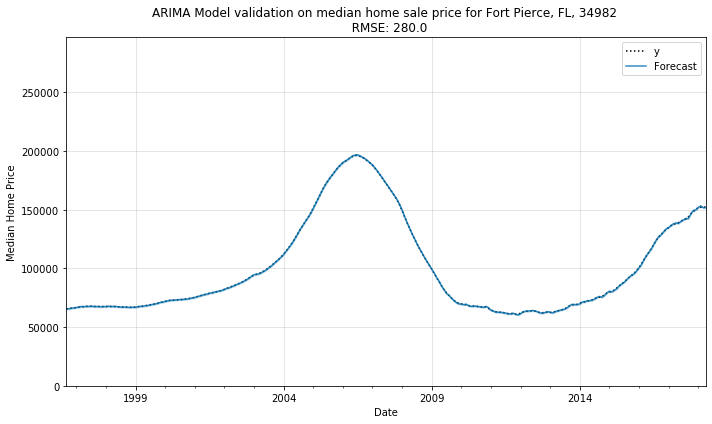

In [34]:
ar.plot_model_validation(pred, pred_conf, df_zip, df, zipcode)

### Calulate the Root Mean Square Error for comparison to Prophet Models

In [29]:
ar.ARIMA_rmse(pred, df_zip)

The Root Mean Squared Error of our forecasts is 279.7


279.70163019316794

## Producing and Visualizing Forecasts

We will now use our ARIMA time series model to forecast future values. 

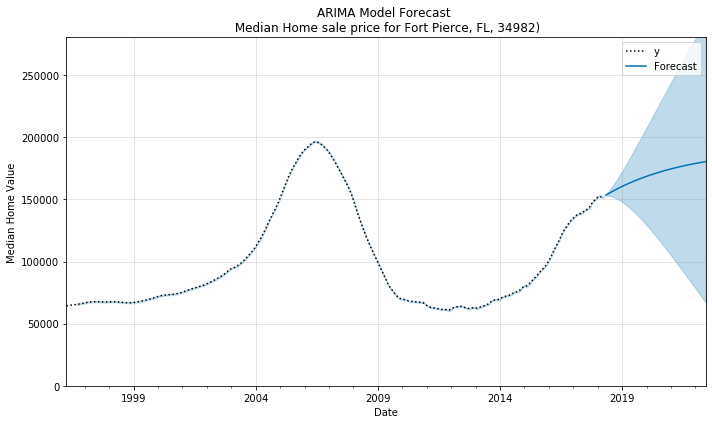

In [36]:
ar.ARIMA_forecast(df_zip, df, output, 50, zipcode)

### Pipline all of the above


In [49]:
#ar.ARIMA_Analysis(df, zipcode, param_combos = 4, forecast_steps=50)
    

### Run the ARIMA analysis for our top 5 zipcodes

From our precious analysis using Facebook Prophet (see other notebook) we have determined the followin 5 zip codes 
are worthy of further exploration. 

[34982, 33982, 34951, 37209, 15201]


In [51]:
zipcodes = [34982, 33982, 34951, 37209, 15201]

ARIMA (0, 0, 0) : AIC Calculated =6867.986508733736
ARIMA (0, 0, 1) : AIC Calculated =12774.799643436323
ARIMA (0, 0, 2) : AIC Calculated =6533.073548811351
ARIMA (0, 0, 3) : AIC Calculated =8307.754655571858
ARIMA (0, 0, 4) : AIC Calculated =7652.546447384641
ARIMA (0, 0, 5) : AIC Calculated =7248.374451393656
ARIMA (0, 1, 0) : AIC Calculated =4720.640987812769
ARIMA (0, 1, 1) : AIC Calculated =4361.456573244114
ARIMA (0, 1, 2) : AIC Calculated =4095.9445126862433
ARIMA (0, 1, 3) : AIC Calculated =3941.753971983573
ARIMA (0, 1, 4) : AIC Calculated =3891.855714339726
ARIMA (0, 1, 5) : AIC Calculated =3847.0370191139154
ARIMA (0, 2, 0) : AIC Calculated =3761.2093269636357
ARIMA (0, 2, 1) : AIC Calculated =3689.008230522384
ARIMA (0, 2, 2) : AIC Calculated =3674.353961656657
ARIMA (0, 2, 3) : AIC Calculated =3656.4220405286064
ARIMA (0, 2, 4) : AIC Calculated =3638.2637850600017
ARIMA (0, 2, 5) : AIC Calculated =3624.758117895597
ARIMA (0, 3, 0) : AIC Calculated =3819.3993941906656
ARIMA

ARIMA (4, 2, 2) : AIC Calculated =3663.102875402782
ARIMA (4, 2, 3) : AIC Calculated =3655.2061546082555
ARIMA (4, 2, 4) : AIC Calculated =3643.135057197148
ARIMA (4, 2, 5) : AIC Calculated =3626.4181524261403
ARIMA (4, 3, 0) : AIC Calculated =3671.774949766621
ARIMA (4, 3, 1) : AIC Calculated =3643.0544455593194
ARIMA (4, 3, 2) : AIC Calculated =3644.642244483446
ARIMA (4, 3, 3) : AIC Calculated =3646.7780614450962
ARIMA (4, 3, 4) : AIC Calculated =3630.6729966944513
ARIMA (4, 3, 5) : AIC Calculated =3620.3018881125863
ARIMA (4, 4, 0) : AIC Calculated =3769.1582577867566
ARIMA (4, 4, 1) : AIC Calculated =3706.7227598171903
ARIMA (4, 4, 2) : AIC Calculated =3736.1061711415723
ARIMA (4, 4, 3) : AIC Calculated =3654.5190677683477
ARIMA (4, 4, 4) : AIC Calculated =3647.1373031733606
ARIMA (4, 4, 5) : AIC Calculated =3628.0632028372193
ARIMA (4, 5, 0) : AIC Calculated =3900.768870293222
ARIMA (4, 5, 1) : AIC Calculated =3776.360771106839
ARIMA (4, 5, 2) : AIC Calculated =3785.843634172479


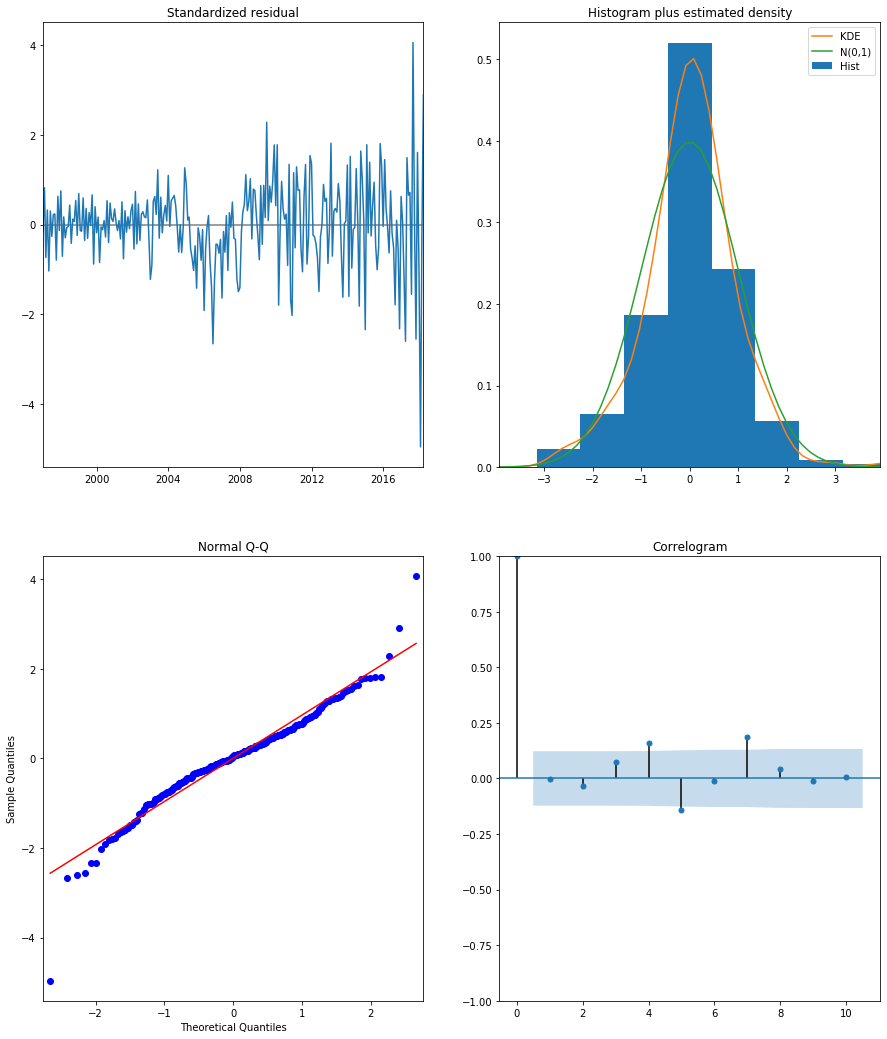

The Root Mean Squared Error of our forecasts is 280.58


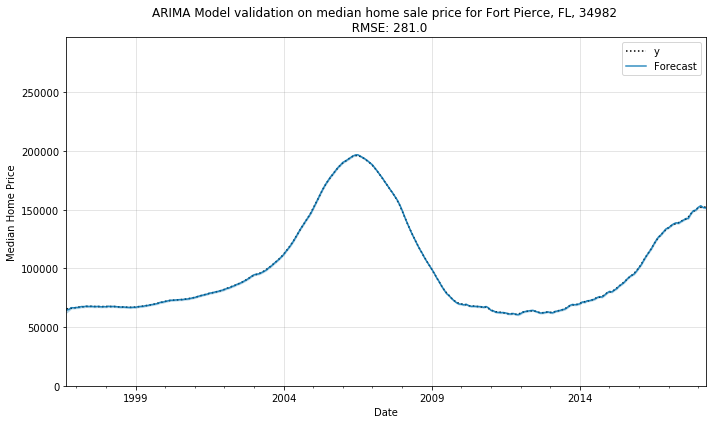

The Root Mean Squared Error of our forecasts is 280.58


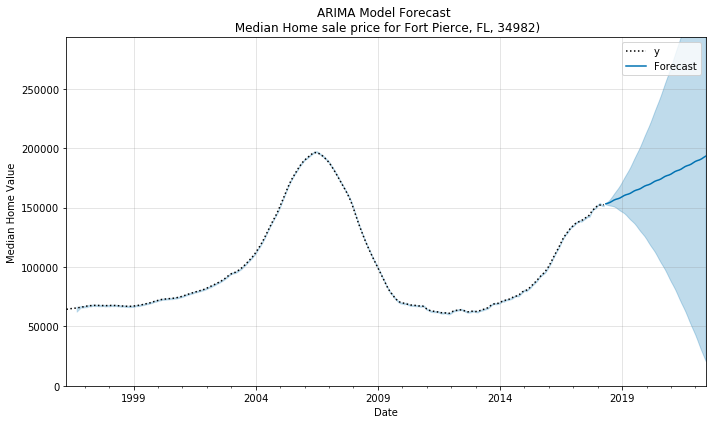

ARIMA (0, 0, 0) : AIC Calculated =6978.424033244566
ARIMA (0, 0, 1) : AIC Calculated =6761.486106521377
ARIMA (0, 0, 2) : AIC Calculated =6694.101866756193
ARIMA (0, 0, 3) : AIC Calculated =8473.610646228051
ARIMA (0, 0, 4) : AIC Calculated =7807.194943485971
ARIMA (0, 0, 5) : AIC Calculated =7395.782891329924
ARIMA (0, 1, 0) : AIC Calculated =4865.078216163773
ARIMA (0, 1, 1) : AIC Calculated =4532.51565279279
ARIMA (0, 1, 2) : AIC Calculated =4247.760789229086
ARIMA (0, 1, 3) : AIC Calculated =4147.688567648447
ARIMA (0, 1, 4) : AIC Calculated =4082.8557899062325
ARIMA (0, 1, 5) : AIC Calculated =4063.7760908957225
ARIMA (0, 2, 0) : AIC Calculated =4219.66094121519
ARIMA (0, 2, 1) : AIC Calculated =4103.3383748356155
ARIMA (0, 2, 2) : AIC Calculated =4067.5300874164045
ARIMA (0, 2, 3) : AIC Calculated =4009.749996776706
ARIMA (0, 2, 4) : AIC Calculated =3984.041680964244
ARIMA (0, 2, 5) : AIC Calculated =3970.4565190071835
ARIMA (0, 3, 0) : AIC Calculated =4242.257395845994
ARIMA (0,

ARIMA (4, 2, 2) : AIC Calculated =4047.318350335229
ARIMA (4, 2, 3) : AIC Calculated =4003.8411621942864
ARIMA (4, 2, 4) : AIC Calculated =3988.907805018197
ARIMA (4, 2, 5) : AIC Calculated =3988.1936601671623
ARIMA (4, 3, 0) : AIC Calculated =4078.90093120383
ARIMA (4, 3, 1) : AIC Calculated =4029.8150350131355
ARIMA (4, 3, 2) : AIC Calculated =4022.139829164038
ARIMA (4, 3, 3) : AIC Calculated =4013.748390971543
ARIMA (4, 3, 4) : AIC Calculated =3985.122462796182
ARIMA (4, 3, 5) : AIC Calculated =4004.9266592919394
ARIMA (4, 4, 0) : AIC Calculated =4182.5070444983685
ARIMA (4, 4, 1) : AIC Calculated =4076.904749621775
ARIMA (4, 4, 2) : AIC Calculated =4083.3401498222925
ARIMA (4, 4, 3) : AIC Calculated =4079.990188873733
ARIMA (4, 4, 4) : AIC Calculated =4014.7671829026804
ARIMA (4, 4, 5) : AIC Calculated =3987.593677796056
ARIMA (4, 5, 0) : AIC Calculated =4303.1901829258295
ARIMA (4, 5, 1) : AIC Calculated =4173.131124703617
ARIMA (4, 5, 2) : AIC Calculated =4184.657523678658
ARIMA

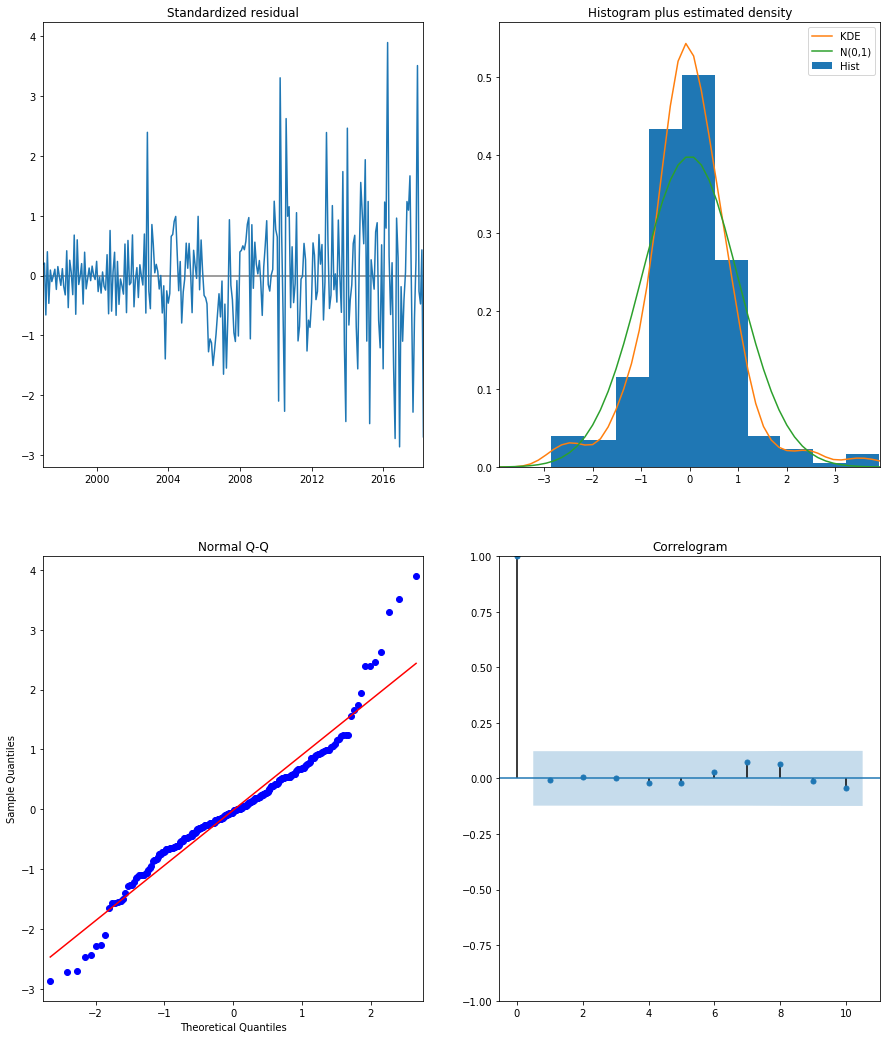

The Root Mean Squared Error of our forecasts is 804.11


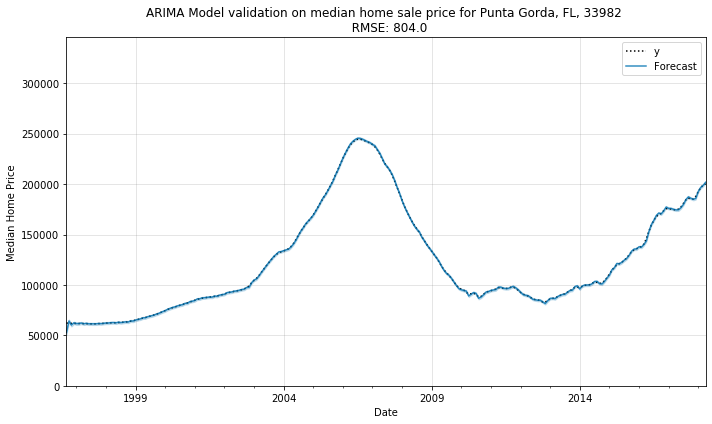

The Root Mean Squared Error of our forecasts is 804.11


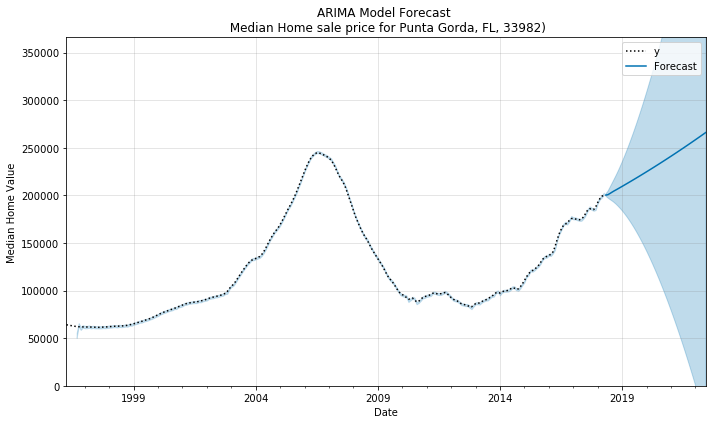

ARIMA (0, 0, 0) : AIC Calculated =6885.740432160234
ARIMA (0, 0, 1) : AIC Calculated =6669.550864300221
ARIMA (0, 0, 2) : AIC Calculated =6602.150671154229
ARIMA (0, 0, 3) : AIC Calculated =6567.445988594165
ARIMA (0, 0, 4) : AIC Calculated =7698.475527445655
ARIMA (0, 0, 5) : AIC Calculated =7340.526026030388
ARIMA (0, 1, 0) : AIC Calculated =4706.102201464776
ARIMA (0, 1, 1) : AIC Calculated =4361.56547869148
ARIMA (0, 1, 2) : AIC Calculated =4086.7393598158997
ARIMA (0, 1, 3) : AIC Calculated =3975.9024835457644
ARIMA (0, 1, 4) : AIC Calculated =3869.78925798702
ARIMA (0, 1, 5) : AIC Calculated =3851.6554910315353
ARIMA (0, 2, 0) : AIC Calculated =3834.39207652274
ARIMA (0, 2, 1) : AIC Calculated =3754.136853905972
ARIMA (0, 2, 2) : AIC Calculated =3741.8118287215693
ARIMA (0, 2, 3) : AIC Calculated =3716.071001574381
ARIMA (0, 2, 4) : AIC Calculated =3697.2270243984995
ARIMA (0, 2, 5) : AIC Calculated =3682.6531589592596
ARIMA (0, 3, 0) : AIC Calculated =3867.0865534997283
ARIMA (0

ARIMA (4, 2, 2) : AIC Calculated =3737.0380344416917
ARIMA (4, 2, 3) : AIC Calculated =3718.5542814542378
ARIMA (4, 2, 4) : AIC Calculated =3697.771732461202
ARIMA (4, 2, 5) : AIC Calculated =3682.749645391158
ARIMA (4, 3, 0) : AIC Calculated =3763.219533241785
ARIMA (4, 3, 1) : AIC Calculated =3722.861609585044
ARIMA (4, 3, 2) : AIC Calculated =3724.1423665906364
ARIMA (4, 3, 3) : AIC Calculated =3711.9755393025293
ARIMA (4, 3, 4) : AIC Calculated =3691.9392664051356
ARIMA (4, 3, 5) : AIC Calculated =3687.4797982210675
ARIMA (4, 4, 0) : AIC Calculated =3865.514568757267
ARIMA (4, 4, 1) : AIC Calculated =3783.2658903339207
ARIMA (4, 4, 2) : AIC Calculated =3826.1715685915515
ARIMA (4, 4, 3) : AIC Calculated =3804.368698396619
ARIMA (4, 4, 4) : AIC Calculated =3715.2677180117585
ARIMA (4, 4, 5) : AIC Calculated =3689.947042982928
ARIMA (4, 5, 0) : AIC Calculated =3991.014094390812
ARIMA (4, 5, 1) : AIC Calculated =3863.5215978303604
ARIMA (4, 5, 2) : AIC Calculated =3868.380069946493
AR

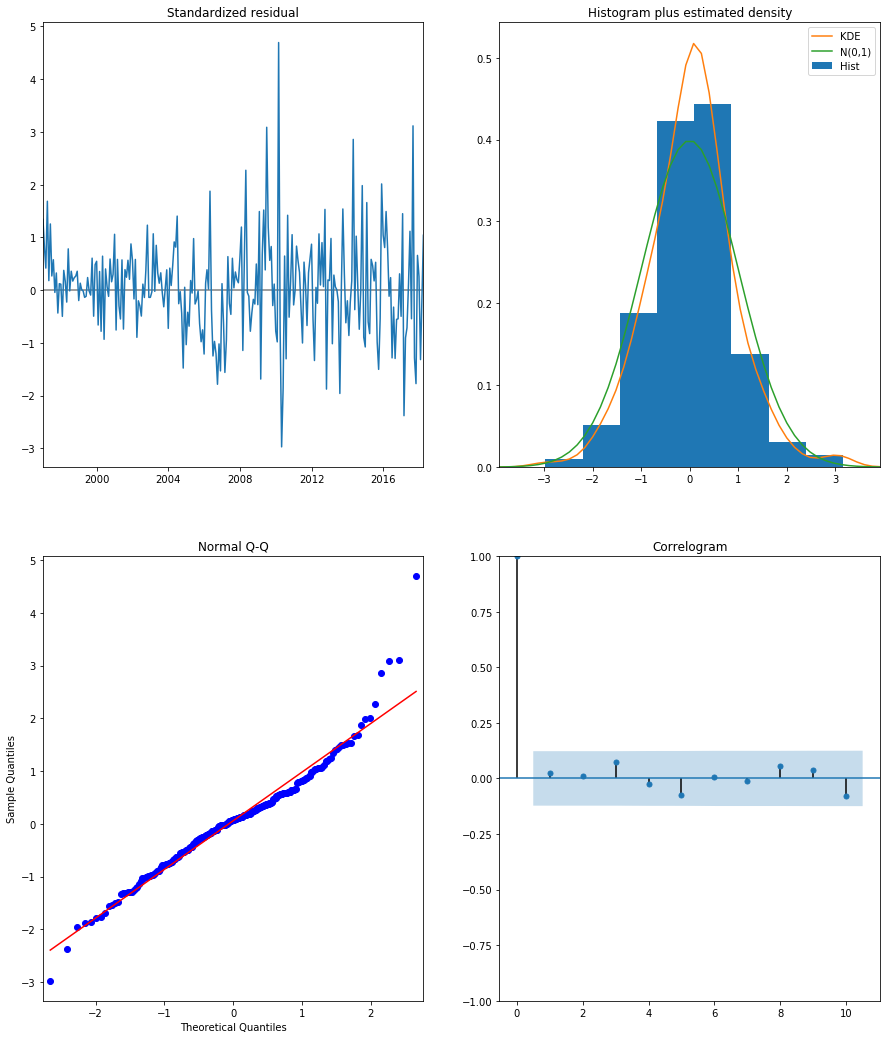

The Root Mean Squared Error of our forecasts is 464.72


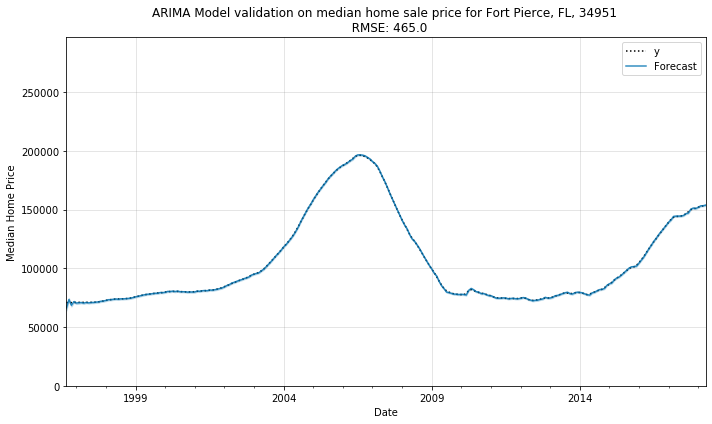

The Root Mean Squared Error of our forecasts is 464.72


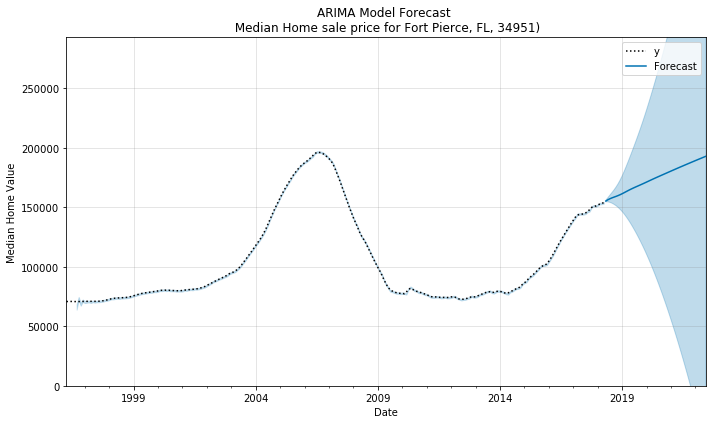

ARIMA (0, 0, 0) : AIC Calculated =7074.615152706601
ARIMA (0, 0, 1) : AIC Calculated =6857.547683404462
ARIMA (0, 0, 2) : AIC Calculated =6789.309181899525
ARIMA (0, 0, 3) : AIC Calculated =8699.497020524868
ARIMA (0, 0, 4) : AIC Calculated =8000.339199446667
ARIMA (0, 0, 5) : AIC Calculated =7619.926301021484
ARIMA (0, 1, 0) : AIC Calculated =4659.383326773965
ARIMA (0, 1, 1) : AIC Calculated =4318.4777487280535
ARIMA (0, 1, 2) : AIC Calculated =4051.201056915829
ARIMA (0, 1, 3) : AIC Calculated =3950.2078146065587
ARIMA (0, 1, 4) : AIC Calculated =3875.0750511922324
ARIMA (0, 1, 5) : AIC Calculated =3899.887053106124
ARIMA (0, 2, 0) : AIC Calculated =3987.7594856004534
ARIMA (0, 2, 1) : AIC Calculated =3878.1693846587805
ARIMA (0, 2, 2) : AIC Calculated =3852.3521560691725
ARIMA (0, 2, 3) : AIC Calculated =3803.1558711065336
ARIMA (0, 2, 4) : AIC Calculated =3778.6471999193554
ARIMA (0, 2, 5) : AIC Calculated =3764.309387825917
ARIMA (0, 3, 0) : AIC Calculated =4012.3679539175155
ARI

ARIMA (4, 2, 2) : AIC Calculated =3805.9929565604452
ARIMA (4, 2, 3) : AIC Calculated =3806.740511264095
ARIMA (4, 2, 4) : AIC Calculated =3787.5099224931455
ARIMA (4, 2, 5) : AIC Calculated =3760.8529026492383
ARIMA (4, 3, 0) : AIC Calculated =3850.390148997465
ARIMA (4, 3, 1) : AIC Calculated =3848.2113258225486
ARIMA (4, 3, 2) : AIC Calculated =3799.908431067295
ARIMA (4, 3, 3) : AIC Calculated =3814.967222996739
ARIMA (4, 3, 4) : AIC Calculated =3782.7781921562682
ARIMA (4, 3, 5) : AIC Calculated =3763.4512305959133
ARIMA (4, 4, 0) : AIC Calculated =3966.676635148387
ARIMA (4, 4, 1) : AIC Calculated =3868.0019948713843
ARIMA (4, 4, 2) : AIC Calculated =3825.7517601122236
ARIMA (4, 4, 3) : AIC Calculated =3817.286833948481
ARIMA (4, 4, 4) : AIC Calculated =3813.2214343417463
ARIMA (4, 4, 5) : AIC Calculated =3780.7933182149545
ARIMA (4, 5, 0) : AIC Calculated =4093.6875393954283
ARIMA (4, 5, 1) : AIC Calculated =3960.486177290052
ARIMA (4, 5, 2) : AIC Calculated =3909.562305485925
A

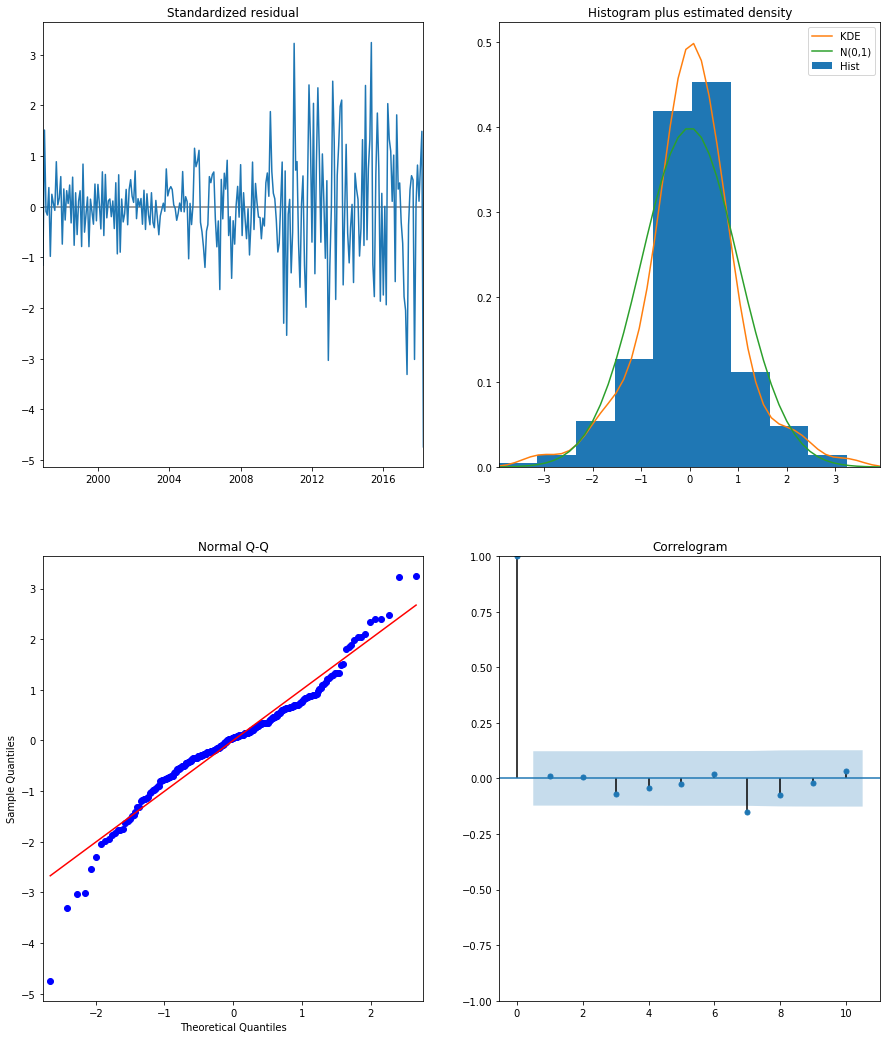

The Root Mean Squared Error of our forecasts is 364.75


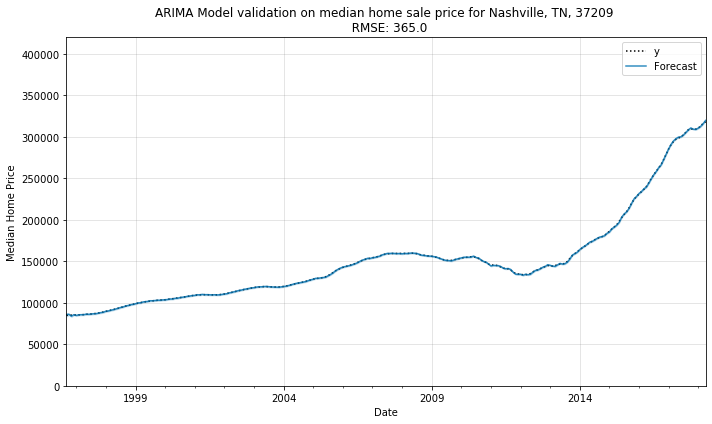

The Root Mean Squared Error of our forecasts is 364.75


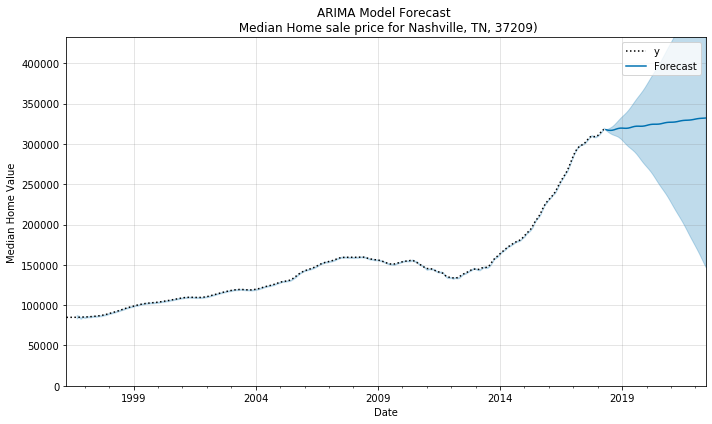

ARIMA (0, 0, 0) : AIC Calculated =6695.3792264607155
ARIMA (0, 0, 1) : AIC Calculated =6479.882111199229
ARIMA (0, 0, 2) : AIC Calculated =6412.920342436911
ARIMA (0, 0, 3) : AIC Calculated =7914.6410257965845
ARIMA (0, 0, 4) : AIC Calculated =7428.036157706607
ARIMA (0, 0, 5) : AIC Calculated =7167.897108282052
ARIMA (0, 1, 0) : AIC Calculated =4456.827788905307
ARIMA (0, 1, 1) : AIC Calculated =4149.407556049664
ARIMA (0, 1, 2) : AIC Calculated =3925.9888021450047
ARIMA (0, 1, 3) : AIC Calculated =3844.6707544663886
ARIMA (0, 1, 4) : AIC Calculated =3822.546580546005
ARIMA (0, 1, 5) : AIC Calculated =3793.1446828157814
ARIMA (0, 2, 0) : AIC Calculated =3919.989560805165
ARIMA (0, 2, 1) : AIC Calculated =3833.071137134894
ARIMA (0, 2, 2) : AIC Calculated =3819.8223654270987
ARIMA (0, 2, 3) : AIC Calculated =3756.474885206099
ARIMA (0, 2, 4) : AIC Calculated =3738.408157091713
ARIMA (0, 2, 5) : AIC Calculated =3724.570481048321
ARIMA (0, 3, 0) : AIC Calculated =3968.961224147573
ARIMA 

ARIMA (4, 2, 1) : AIC Calculated =3756.0047260710244
ARIMA (4, 2, 2) : AIC Calculated =3757.7272768464754
ARIMA (4, 2, 3) : AIC Calculated =3760.244776564693
ARIMA (4, 2, 4) : AIC Calculated =3735.11035633679
ARIMA (4, 2, 5) : AIC Calculated =3707.6781776953085
ARIMA (4, 3, 0) : AIC Calculated =3846.2479701082902
ARIMA (4, 3, 1) : AIC Calculated =3777.2486915777954
ARIMA (4, 3, 2) : AIC Calculated =3768.494608014971
ARIMA (4, 3, 3) : AIC Calculated =3783.4995925460626
ARIMA (4, 3, 4) : AIC Calculated =3738.1046866786055
ARIMA (4, 3, 5) : AIC Calculated =3713.8581140545994
ARIMA (4, 4, 0) : AIC Calculated =3949.6324794287243
ARIMA (4, 4, 1) : AIC Calculated =3845.5797730816676
ARIMA (4, 4, 2) : AIC Calculated =3808.031661540691
ARIMA (4, 4, 3) : AIC Calculated =3876.755884493952
ARIMA (4, 4, 4) : AIC Calculated =3770.515174431761
ARIMA (4, 4, 5) : AIC Calculated =3736.917982348059
ARIMA (4, 5, 0) : AIC Calculated =4063.7488184384356
ARIMA (4, 5, 1) : AIC Calculated =3941.860304920011
AR

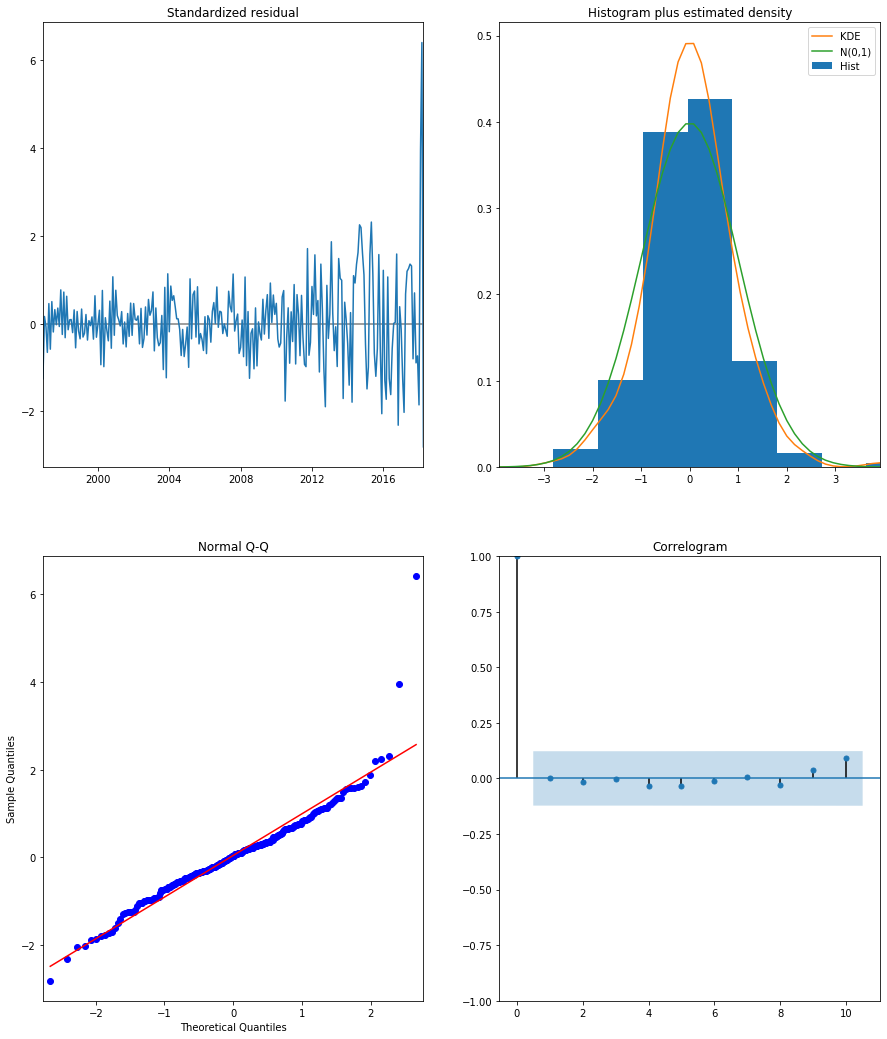

The Root Mean Squared Error of our forecasts is 342.42


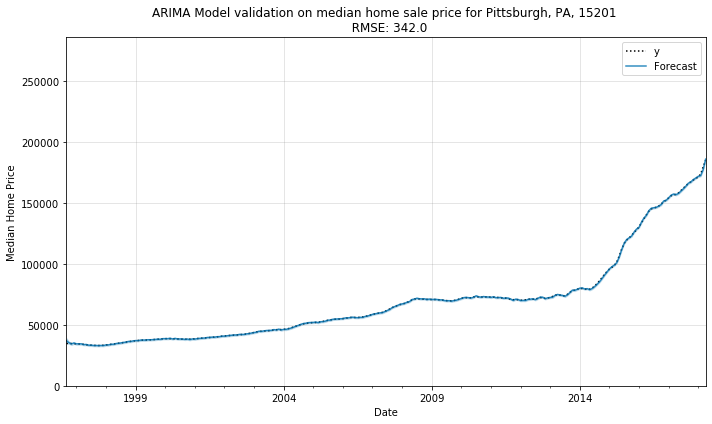

The Root Mean Squared Error of our forecasts is 342.42


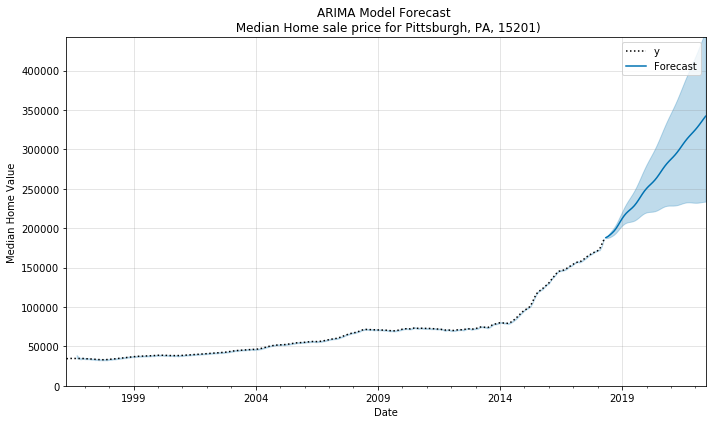

In [53]:
# WARNING Depending on the selection for param_combos this cell can take quite a while to run!!
for zipcode in zipcodes:
    ar.ARIMA_Analysis(df, zipcode, param_combos = 6, 50)

Running the above cell with param_combos = 6 results in the following `p,d,q` parameter combos for each zipcode:

- 15201 : (4,2,5)
- 37209 : (2,2,5)
- 34951 : (3,3,5)
- 33982 : (3,3,5)
- 34982 : (2,3,5)

### Conclusions

 1. Each model is well fit and able to forecast the historic data with small amount of error (RMSE ranging from 280-800)
 2. Many of the forecasted confidence intervals are so wide, that it would be difficult to take decisive action based on the forecast. The exception here is the model for Pittsburg. 
 3. The models are less confident, and less optimisti than the Prohpet Forecast
 4. All of the models used the maximum value for `q` : `5`. 
        - `q` is the number of lagged forecast errors in the prediction equation, and works as a smoothing trend.
        - Accroding to some sources having high `p` and `q` values can lead to overfitting. 
        - Future crossvalidation could test for this. 
 